In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [4]:
cd ../

/atlas/u/kechoi/multi-fairgen


In [6]:
cd src

/atlas/u/kechoi/multi-fairgen/src


In [7]:
from classification.models.mlp import MLPClassifier, MLPClassifierv2
from classification.models.flow_mlp import FlowClassifier
import argparse
import yaml

# Helper functions

In [8]:
def logsumexp_1p(s):
    # numerically stable implementation of log sigmoid via logsumexp
    # NOTE: this assumes that you feed in -s for the positive probabilities
    if len(s.size()) == 2:
        s = s.squeeze()
    x = torch.stack([s, torch.zeros_like(s)], -1)
    val, _ = torch.max(x, 1)
    val = val.repeat(2,1).T
    logsigmoid = torch.clamp(s, 0) + torch.log(
        torch.sum(torch.exp(x - val), 1))

    return -logsigmoid

# Dataset

In [9]:
import torch
from torch.distributions import Normal

In [10]:
p = Normal(0, 1)
q = Normal(3, 1)

In [11]:
px = p.sample((2000,2))
qx = q.sample((2000,2))

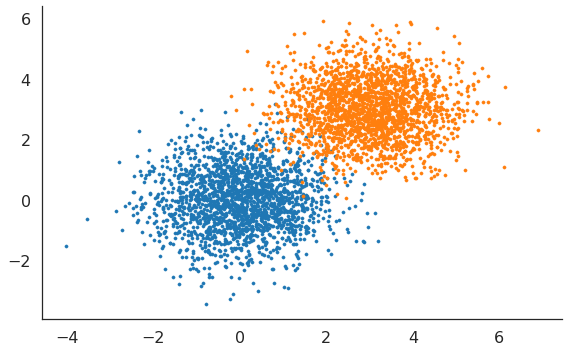

In [12]:
plt.figure(figsize=(8,5))
plt.scatter(px[:,0], px[:,1], label='px', s=10)
plt.scatter(qx[:,0], qx[:,1], label='qx', s=10)

plt.tight_layout()
sns.despine()

In [13]:
true_xs = torch.cat([px, qx])
true_xs.shape

torch.Size([4000, 2])

In [14]:
true_ratios = torch.exp((q.log_prob(true_xs).sum(-1) - p.log_prob(true_xs).sum(-1)))

In [15]:
true_log_r = torch.log(true_ratios)

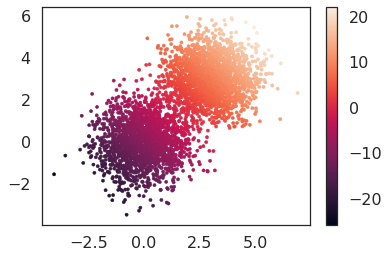

In [16]:
plt.scatter(true_xs[:,0].data.cpu().numpy(), true_xs[:,1].data.cpu().numpy(), s=10, c=true_log_r.data.cpu().numpy())
plt.colorbar()

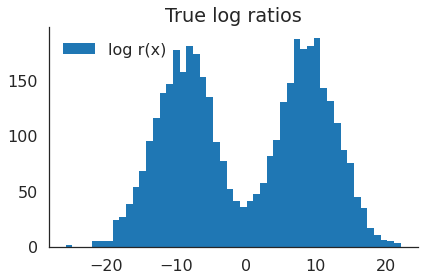

In [17]:
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('True log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

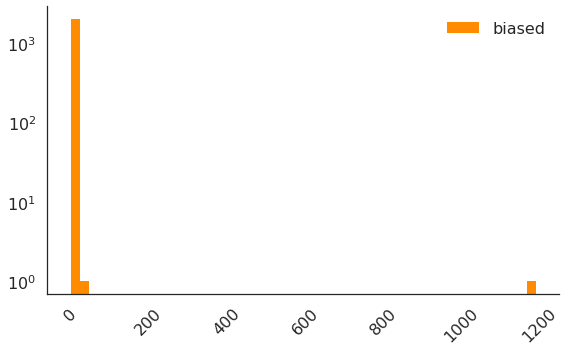

In [18]:
plt.figure(figsize=(8,5))
_ = plt.hist(torch.exp(true_log_r).data.cpu().numpy()[0:2000], bins=50, log=True ,label='biased', color='darkorange')
plt.xticks(rotation=45)

plt.legend()
sns.despine()
plt.tight_layout()

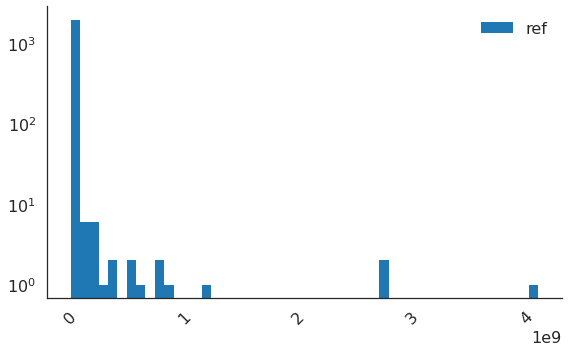

In [19]:
plt.figure(figsize=(8,5))
_ = plt.hist(torch.exp(true_log_r).data.cpu().numpy()[2000:], bins=50, log=True ,label='ref')
plt.xticks(rotation=45)

plt.legend()
sns.despine()
plt.tight_layout()

------

--------

# Jointly trained flow classifier

In [21]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    if isinstance(config, list):
        # from creating config files
        for i in range(len(config)):
            for key, value in config[i].items():
                if isinstance(value, dict):
                    new_value = dict2namespace(value)
                else:
                    new_value = value
                setattr(namespace, key, new_value)
    else:
        # vanilla training
        for key, value in config.items():
            if isinstance(value, dict):
                new_value = dict2namespace(value)
            else:
                new_value = value
            setattr(namespace, key, new_value)
    return namespace

In [22]:
alpha = 0.1
device = 'cuda'

In [23]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [33]:
fcs = [(c, state['state_dict'][c].data.cpu().numpy()) for c in state['state_dict'].keys() if 'fc4' in c]

best epoch: 38
best epoch: 170
best epoch: 170
best epoch: 38
best epoch: 170
best epoch: 157
best epoch: 157
best epoch: 157
best epoch: 158
best epoch: 199
best epoch: 150
best epoch: 150


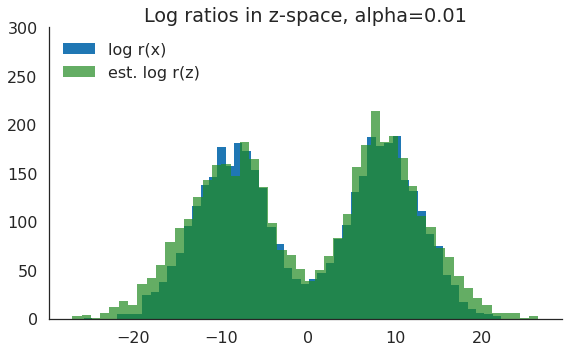

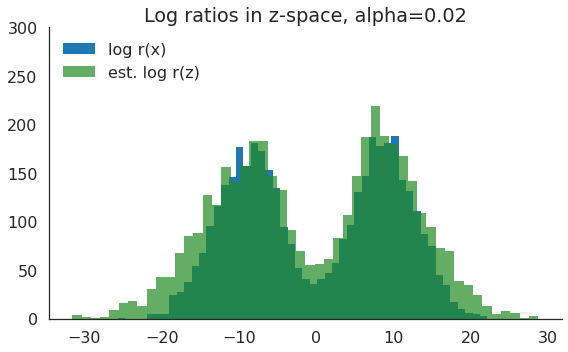

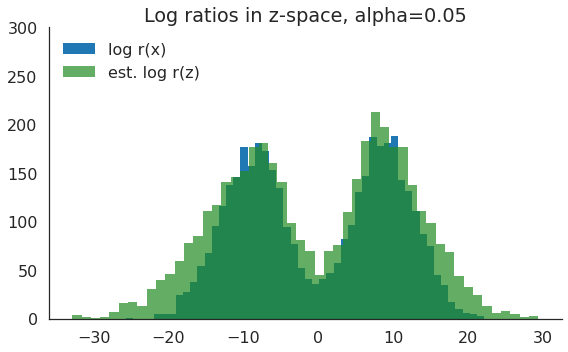

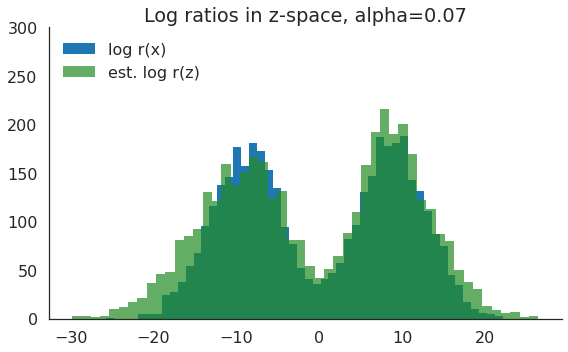

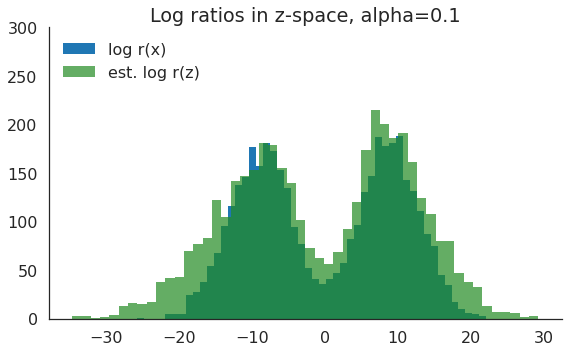

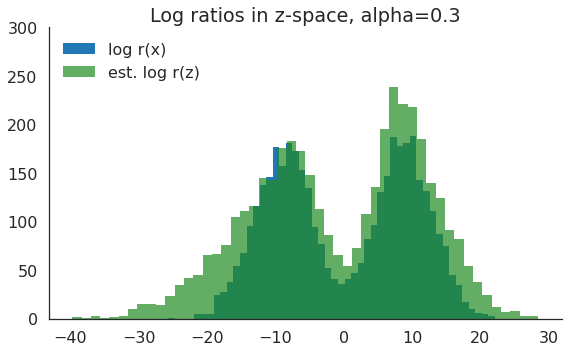

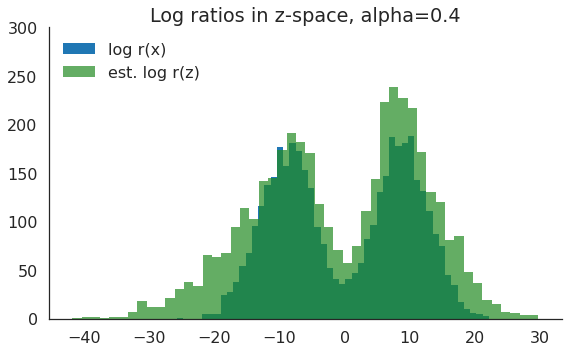

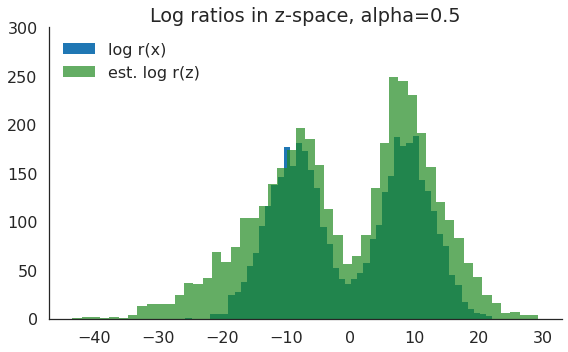

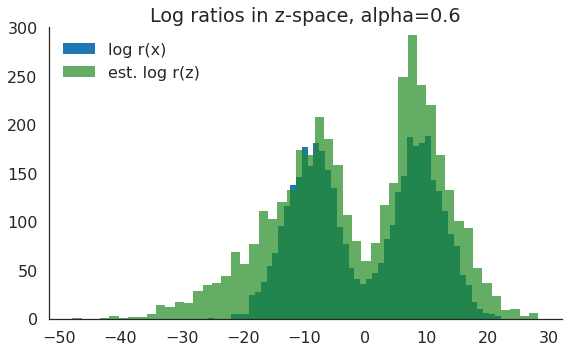

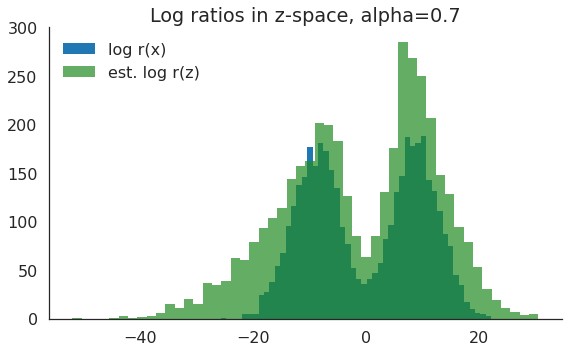

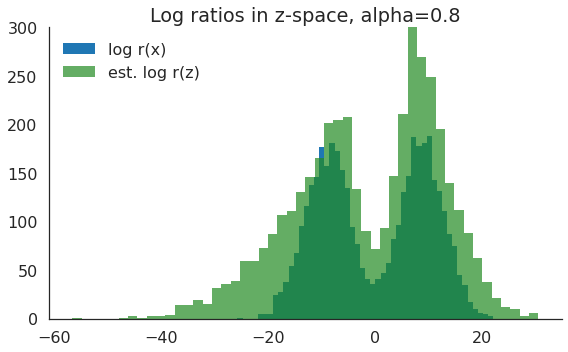

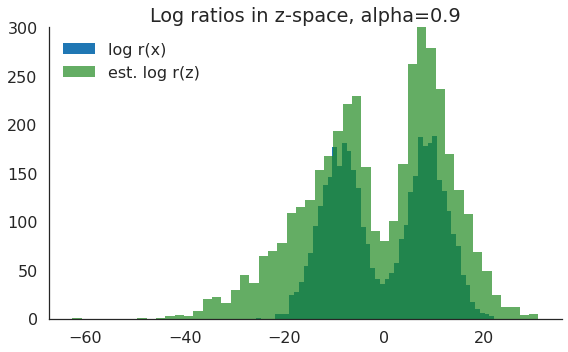

In [61]:
d = {}

for alpha in [0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
# for alpha in [0.001, 0.005, 0.007, 0.01, 0.02, 0.05, 0.07, 0.1]:
    try:
        with open(os.path.join('configs/classification/gmm/joint_sweep/joint_flow_mlp_perc1.0_alpha{}.yaml'.format(alpha)), 'r') as f:
            config = yaml.safe_load(f)
        new_config = dict2namespace(config)

        # load model
        joint_flow_mlp = FlowClassifier(new_config)
        restore_file = 'classification/results/joint_gmm_flow_mlp_perc1.0_alpha{}/checkpoints/model_best.pth'.format(alpha)
        state = torch.load(restore_file, map_location='cuda')
        joint_flow_mlp.load_state_dict(state['state_dict'])
        print('best epoch: {}'.format(state['epoch']))
        joint_flow_mlp = joint_flow_mlp.to(device)
        
        # save weights
        d[alpha] = [(c, state['state_dict'][c].data.cpu().numpy()) for c in state['state_dict'].keys() if 'fc4' in c]

        # get dres
        logits, probas = joint_flow_mlp(true_xs.cuda())
        joint_flow_log_ratios = (logsumexp_1p(-logits) - logsumexp_1p(logits)).squeeze()

        # plot ratios
        plt.figure(figsize=(8,5))
        _ = plt.hist(true_log_r.detach().data.cpu().numpy(), bins=50, label='log r(x)')
        _ = plt.hist(joint_flow_log_ratios.data.cpu().numpy(), bins=50, label='est. log r(z)', alpha=0.7, color='forestgreen')
        plt.title('Log ratios in z-space, alpha={}'.format(alpha))
        plt.ylim(0, 300)

        plt.legend(loc='upper left')
        sns.despine()
        plt.tight_layout()
    except:
        pass

----

# What are some differences in the classifiers?

In [62]:
for key in d.keys():
    print(key, np.linalg.norm(d[key][0][1]), d[key][1][1])
    print(np.linalg.norm(np.hstack([d[key][0][1], d[key][1][1].reshape(1,1)])))
    print('---')

0.01 1.0674149 [0.05411964]
1.068786
---
0.02 1.1730125 [0.05699415]
1.1743963
---
0.05 1.0109782 [0.05608978]
1.012533
---
0.07 0.9121972 [0.05475106]
0.9138388
---
0.1 0.9294508 [0.05669992]
0.9311786
---
0.3 0.8891893 [0.0558415]
0.890941
---
0.4 0.8828728 [0.05596031]
0.88464457
---
0.5 0.8736765 [0.05590541]
0.87546325
---
0.6 0.8769213 [0.05421689]
0.8785957
---
0.7 0.852854 [0.05414814]
0.8545712
---
0.8 0.83172184 [0.05470269]
0.83351886
---
0.9 0.8007745 [0.05426442]
0.80261105
---


In [57]:
d[key][0][1].shape

(1, 200)

In [59]:
np.hstack([d[key][0][1], d[key][1][1].reshape(1,1)]).shape

(1, 201)

In [63]:
import torch.nn as nn

In [64]:
for key in d.keys():
    print(key, nn.utils.weight_norm(torch.from_numpy(d[key][0][1]), d[key][1][1]))
    print(np.linalg.norm(np.hstack([d[key][0][1], d[key][1][1].reshape(1,1)])))
    print('---')

AttributeError: 'Tensor' object has no attribute '_forward_pre_hooks'